In [521]:
import numpy as np 
import matplotlib.pyplot as plt

In [522]:
angle,time,time_str = [],[],[]
with open('angle_time.csv', 'r') as f:
    line = f.readline() 
    while line: 
        a,ts = line.split(',')
        h,m = ts.split(':')
        t = int(h)*60 + int(m)

        angle.append(int(a))
        time.append(t)
        time_str.append(ts)

        line = f.readline() 

angles = np.array(angle)
times = np.array(time) 
times = times - times.min()
times = times / times.max()

In [523]:
END_ASTRO = 102
END_SUNRISE = 85
NUM_STEPS = (angles >= END_SUNRISE).sum()
HUE_CHANGE = 120/255
MAX_HUE = (255+40)/255
SAT_MIN = 32/255

HUE_POLY = 1.5
SAT_POLY = 1
VAL_POLY = 1/2

starting_hues = np.array([170,190,210,220])/255

In [524]:
import matplotlib.colors as mcolors

def draw_rectangle_gradient(ax, x1, y1, width, height, color1, color2, n=100):
    # Create an array of the linear gradient between the two colors
    gradient_colors = []
    for segment in np.linspace(0, width, n):
        interp_color = [(1 - segment / width) * color1[j] + (segment / width) * color2[j] for j in range(3)]
        if interp_color[0] > 1: 
            interp_color[0] -= 1

        gradient_colors.append(mcolors.hsv_to_rgb(interp_color))
    for i, color in enumerate(gradient_colors):
        ax.add_patch(plt.Rectangle((x1 + width/n * i, y1), width/n, height, color=color, linewidth=0, zorder=0))
    return ax

def green_filter(h): 
    filter_after = 0
    for h_ in h: 
        if h_ > (45+255)/255:
            break 
        filter_after += 1 

    h[filter_after:] += 75/255

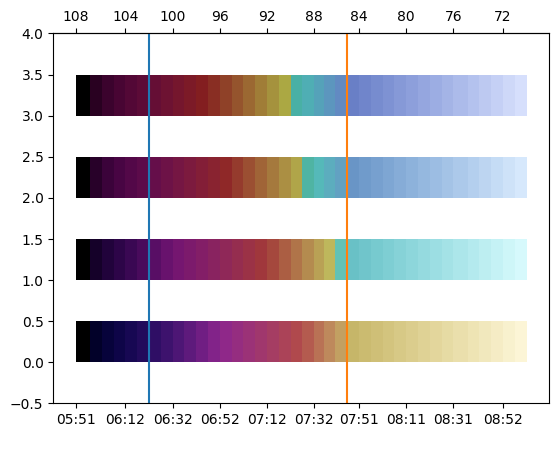

array([1.        , 0.97698658, 0.95397317, 0.93095975, 0.90794634,
       0.88493292, 0.8619195 , 0.83890609, 0.81589267, 0.79287926,
       0.76986584, 0.74685243, 0.72383901, 0.70082559, 0.67781218,
       0.65479876, 0.63178535, 0.60877193, 0.58575851, 0.5627451 ,
       0.53973168, 0.51671827, 0.49370485, 0.47069143, 0.44767802,
       0.4246646 , 0.40165119, 0.37863777, 0.35562436, 0.33261094,
       0.30959752, 0.28658411, 0.26357069, 0.24055728, 0.21754386,
       0.19453044, 0.17151703, 0.14850361, 0.1254902 ])

In [525]:
n = len(time_str)
hues = np.pow(np.linspace(0,1, NUM_STEPS),HUE_POLY) * HUE_CHANGE
sat = -(1-SAT_MIN) * np.pow(np.linspace(0,1, n),SAT_POLY) + 1 
val = np.pow(np.linspace(0,1, n), VAL_POLY)

ax = plt.axes()
for i in range(starting_hues.shape[0]): 
    h = starting_hues[i]
    inc = 0

    v_hues = h + hues 
    green_filter(v_hues)
    #v_hues[v_hues > MAX_HUE] = MAX_HUE

    for j in range(times.shape[0]-1): 
        if j < NUM_STEPS-1:
            c1 = np.array([v_hues[j],sat[j],val[j]])
            c2 = np.array([v_hues[j+1],sat[j+1],val[j+1]])
        else: 
            c1 = np.array([v_hues[-1],sat[j],val[j]])
            c2 = np.array([v_hues[-1],sat[j+1],val[j+1]])

        draw_rectangle_gradient(ax, times[j], i, times[j+1]-times[j], 0.5, c1, c2, n=1)

line1 = times[(angles == END_ASTRO).nonzero()[0]]
line2 = times[(angles == END_SUNRISE).nonzero()[0]]
plt.plot([line1,line1], [-1,4])
plt.plot([line2,line2], [-1,4])

ax.set_ylim(-0.5, len(starting_hues))
ax.set_xticks(times[::4], time_str[::4])
ax_top = ax.secondary_xaxis('top')
ax_top.set_xticks(times[::4], angles[::4])
plt.show()

sat